# Introduction to CNN Keras - Acc 0.997 (top 8%)

## 1、概要

**出于计算的原因，我设置次数为2，如果你想达到99以上的精确度可以将其设置为30。**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# 2、数据准备

## 2.1 加载数据

In [24]:
# Load the data
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

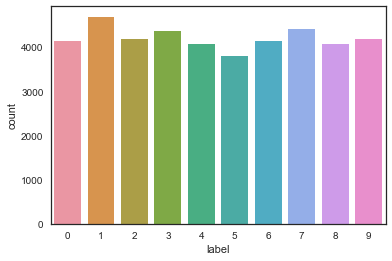

In [25]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

结论：10个数的总数目相似。目标变量分布相对比较平衡

## 2.2 检查空值和缺失值

In [26]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [27]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

结论：训练集和测试集都无缺失值

## 2.3 归一化

CNN在归一化的数据上收敛更快

In [28]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

## 2.4 矩阵变维

In [29]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)  # -1代表所有
test = test.values.reshape(-1,28,28,1)

训练和测试图像（28px x 28px）已经被存入pandas.Dataframe作为784值的1D向量。 我们将所有数据重塑为28x28x1 3D矩阵。

MNIST是灰度图像，因此它只使用一个通道。 对于RGB图像，有3个通道，我们可以将784px的矢量重新映射到28x28x3的3D矩阵。

## 2.5 标签编码（独热码）

In [30]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

多分类问题，一般会对输出进行热编码

## 2.6 拆分训练集合测试集

In [31]:
# Set the random seed
random_seed = 2

# Split the train and the validation set for the fitting. stratify:解决类分布不平衡问题
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, stratify=Y_train, random_state=random_seed)  

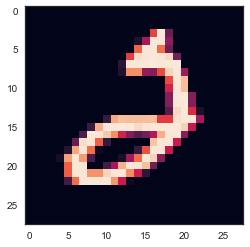

In [32]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

# 3、CNN

## 3.1 定义模型

In [33]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))  # 卷积层
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))  # 最大池化层
model.add(Dropout(0.25))  # 防止过拟合


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())  # Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。Flatten不影响batch的大小。
model.add(Dense(256, activation = "relu"))  # 全连接层
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


## 3.2 设置优化器和学习率衰减

一旦我们的图层被添加到模型中，接下来需要设置评价函数，损失函数和优化算法。

损失函数用来衡量我们的模型在已知标签的图像上表现如何差。这是标签和预测标签之间的错误率。我们使用categorical_crossentropy（多类的对数损失函数，目标需要one-hot编码）。

https://zhuanlan.zhihu.com/p/22252270
优化器选择了RMSprop（使用默认值），它是一个非常有效的优化器。Adagrad、SGD(比RMSprop慢)。

评价函数“准确度”用于评估模型的性能。这个评价函数与损失函数类似，只是在训练模型时不使用评价的结果（仅用于评价）。

In [34]:
# Define the optimizer（优化器：权值更新，优化梯度下降速度）
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [35]:
# Compile the model。优化器optimizer，损失函数loss，指标列表metrics
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

learning rate (LR)。利用Keras.callbacks中的ReduceLROnPlateau函数，如果在3个时期后精度没有提高，我选择将LR减少一半。

In [36]:
# Set a learning rate annealer（学习率衰减）
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)  # 下限

In [37]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

## 3.3 数据增强

为了避免过度拟合问题，我们需要人工扩展我们的手写数字数据集。

**采用数据增强**：灰度，水平翻转，垂直翻转，随机裁剪，颜色，旋转等

改进很重要：准确性从98.114％提高到99.67％

In [38]:
# Without data augmentation i obtained an accuracy of 0.98114
# history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#                     validation_data = (X_val, Y_val), verbose = 2)

In [39]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

# 没有采用vertical_flip和horizontal_flip，因为它可能导致错误分类6和9。
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180) 
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/1
 - 377s - loss: 0.4168 - acc: 0.8658 - val_loss: 0.0557 - val_acc: 0.9833


# 4、评测模型

## 4.1 训练和验证曲线

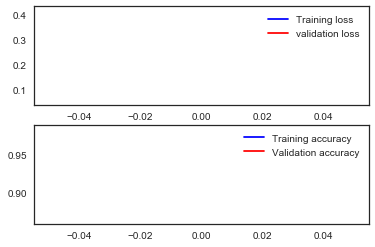

In [40]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 混淆矩阵

混淆矩阵有助于查看模型缺陷。以下是验证结果的混淆矩阵：

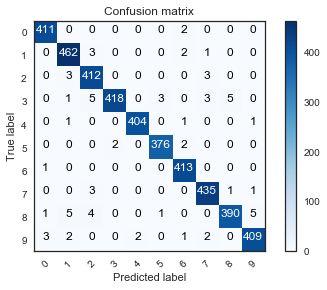

In [41]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

在这里我们可以看到，考虑到验证集的大小（4200个图像），我们的CNN在所有数字上表现都很好，而且几乎没有错误。

但是，似乎我们的CNN在数字4上有一些小问题，他们被错误分类为9.有时在曲线平滑时很难捕捉到4和9之间的差异。

让我们来调查错误（最重要的错误）。为此，我需要弄清楚结果中真实值的概率和预测值的差异。

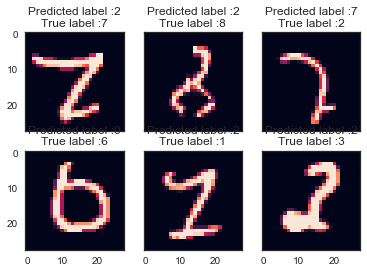

In [42]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
print()
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [43]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability（选择最大数的索引）
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [44]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("./output/cnn_mnist_datagen.csv",index=False)
submission.sample(10)

,ImageId,Label
18040,18041,2
24357,24358,0
13398,13399,5
26378,26379,7
22244,22245,6
16833,16834,8
14889,14890,9
22693,22694,2
7060,7061,5
14878,14879,1
